# Import

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='-1'
os.environ['TF_CUDNN_USE_AUTOTUNE'] ='0'
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import pandas as pd
import numpy as np
import random
np.random.seed(42)
random.seed(42)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.python.keras import backend as K
#SEED
def seed_everything():
    tf.random.set_seed(42)
    tf.keras.utils.set_random_seed(42)
    tf.compat.v1.reset_default_graph()
    tf.config.experimental.enable_op_determinism()
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    K.set_session(sess)
    K.clear_session()
from xgboost import XGBRegressor
from prophet import Prophet
import optuna
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from pmdarima.arima import StepwiseContext
import warnings
warnings.filterwarnings('ignore')
import holidays

#Save requirements
os.system("pip freeze > requirements.txt")

0

In [2]:
df = pd.read_csv('Data/london_merged.csv')
display(df.head(2))

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0


- Metadata:
  - "timestamp" - timestamp field for grouping the data
  - "cnt" - the count of a new bike shares
  - "t1" - real temperature in C
  - "t2" - temperature in C "feels like"
  - "hum" - humidity in percentage
  - "wind_speed" - wind speed in km/h
  - "weather_code" - category of the weather
  - "is_holiday" - boolean field - 1 holiday / 0 non holiday
  - "is_weekend" - boolean field - 1 if the day is weekend
  - "season" - category field meteorological seasons: 0-spring ; 1-summer; 2-fall; 3-winter.
  - "weathe_code" category description:
     - 1 = Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity 
     - 2 = scattered clouds / few clouds 
     - 3 = Broken clouds 
     - 4 = Cloudy 
     - 7 = Rain/ light Rain shower/ Light rain 
     - 10 = rain with thunderstorm 
     - 26 = snowfall 
     - 94 = Freezing Fog

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     17414 non-null  object 
 1   cnt           17414 non-null  int64  
 2   t1            17414 non-null  float64
 3   t2            17414 non-null  float64
 4   hum           17414 non-null  float64
 5   wind_speed    17414 non-null  float64
 6   weather_code  17414 non-null  float64
 7   is_holiday    17414 non-null  float64
 8   is_weekend    17414 non-null  float64
 9   season        17414 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB


# Data Wrangling

In [4]:
#Convert the timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
#Keep records from 2015 and 2016
df = df[(df['timestamp'].dt.year == 2015) | (df['timestamp'].dt.year == 2016)]
#Sort the values by timestamp
df = df.sort_values('timestamp')

In [5]:
#Missing values
df.isnull().sum()

timestamp       0
cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
dtype: int64

- No missing values. But there might be missing timestamps.

In [6]:
#Check for missing timestamps
all_days = pd.date_range(start=df['timestamp'].min(), end=df['timestamp'].max(), freq='h')
missing_days = all_days[~all_days.isin(df['timestamp'])]
print('Number of missing timestamps:', len(missing_days))

Number of missing timestamps: 130


In [7]:
missing_days[0]

Timestamp('2015-01-07 19:00:00')

- 130 timestamps are missing. We will imput them using existing values.

In [8]:
#London holidays
uk_holidays = holidays.UK(years=[df['timestamp'].dt.year.min(), df['timestamp'].dt.year.max()])
uk_holidays

{datetime.date(2016, 3, 25): 'Good Friday', datetime.date(2016, 5, 2): 'May Day', datetime.date(2016, 5, 30): 'Spring Bank Holiday', datetime.date(2016, 1, 1): "New Year's Day", datetime.date(2016, 12, 25): 'Christmas Day', datetime.date(2016, 12, 27): 'Christmas Day (observed)', datetime.date(2016, 12, 26): 'Boxing Day', datetime.date(2015, 4, 3): 'Good Friday', datetime.date(2015, 5, 4): 'May Day', datetime.date(2015, 5, 25): 'Spring Bank Holiday', datetime.date(2015, 1, 1): "New Year's Day", datetime.date(2015, 12, 25): 'Christmas Day', datetime.date(2015, 12, 26): 'Boxing Day', datetime.date(2015, 12, 28): 'Boxing Day (observed)'}

In [9]:
#Create new dataframe using all days
df_full = pd.DataFrame(all_days, columns=['timestamp'])
#Merge with df to get cnt, t1, t2, hum, wind_speed, weather_code, season
df_full = df_full.merge(df[['timestamp', 'cnt', 't1', 't2', 'hum', 'wind_speed', 'weather_code', 'season']], on='timestamp', how='left')
#is_holiday column: 1 if holiday, 0 if not
df_full['is_holiday'] = np.where(df_full['timestamp'].dt.date.isin(uk_holidays), 1, 0)
df_full['is_weekend'] = np.where(df_full['timestamp'].dt.dayofweek.isin([5, 6]), 1, 0)

#Backfill missing values
df_full = df_full.ffill()
df = df_full.copy()

In [10]:
df.isnull().sum()

timestamp       0
cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
season          0
is_holiday      0
is_weekend      0
dtype: int64

In [11]:
missing_days = all_days[~all_days.isin(df['timestamp'])]
print('Number of missing timestamps:', len(missing_days))

Number of missing timestamps: 0


In [12]:
#Set the timestamp as the index
df.set_index('timestamp', inplace=True)
#Set period to 1 hour
df.index = pd.DatetimeIndex(df.index).to_period('h')
df.head(2)

,cnt,t1,t2,hum,wind_speed,weather_code,season,is_holiday,is_weekend
timestamp,,,,,,,,,
2015-01-04 00:00,182.0,3.0,2.0,93.0,6.0,3.0,3.0,0,1
2015-01-04 01:00,138.0,3.0,2.5,93.0,5.0,1.0,3.0,0,1


Index(['cnt', 't1', 't2', 'hum', 'wind_speed', 'weather_code', 'season',
       'is_holiday', 'is_weekend'],
      dtype='object')


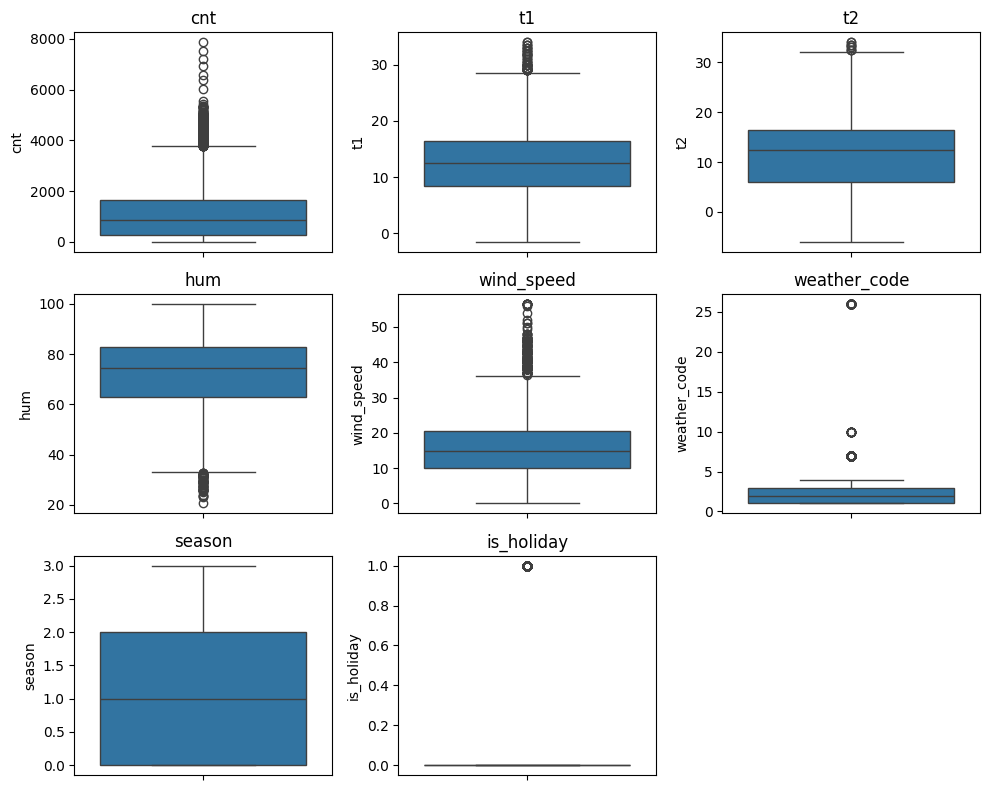

In [13]:
# # Boxplot of all the columns
plt.figure(figsize=(10, 8))
cols = df.columns
print(cols)
for i in range(1, len(cols)):
    plt.subplot(3, 3, i)
    sns.boxplot(df[cols[i-1]])
    plt.title(cols[i-1])
plt.tight_layout()
plt.show()

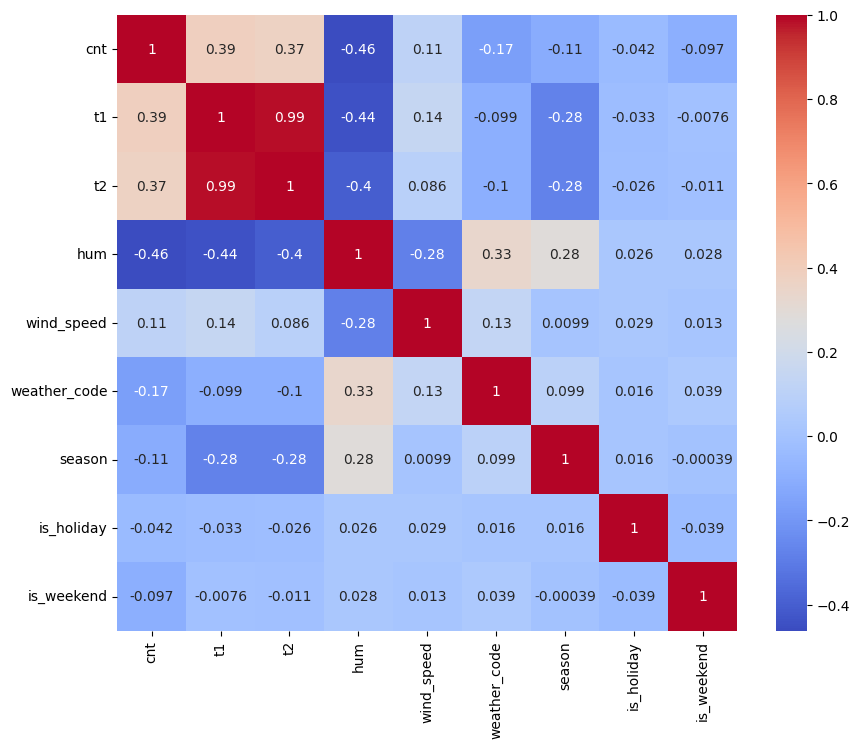

In [14]:
# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

- Real and feels like temperature are highly correlated. Let's use feels like temperature since it is more likely to impact the decision.

In [15]:
#Drop t1
df.drop(['t1'], axis=1, inplace=True)

In [16]:
#Add column with dawn, morning, afternoon, dusk, evening and night based on the hour
df['hour'] = df.index.hour
df['time_of_day'] = pd.cut(df['hour'], bins=[-1, 4, 7, 12, 16, 20, 24], 
                           labels=['night', 'dawn', 'morning', 'afternoon', 'dusk', 'evening'])

df = df.drop('hour', axis=1)

In [17]:
time_of_day_temp_columns = ['night_temp', 
                       'dawn_temp', 
                       'morning_temp', 
                       'afternoon_temp', 
                       'dusk_temp', 
                       'evening_temp']

time_of_day_hum_columns = ['night_hum',
                          'dawn_hum',
                          'morning_hum',
                          'afternoon_hum',
                          'dusk_hum',
                          'evening_hum']

time_of_day_wind_speed_columns = ['night_wind_speed',
                                    'dawn_wind_speed',
                                    'morning_wind_speed',
                                    'afternoon_wind_speed',
                                    'dusk_wind_speed',
                                    'evening_wind_speed']

time_of_day_weather_columns = ['night_weather_code', 
                       'dawn_weather_code', 
                       'morning_weather_code', 
                       'afternoon_weather_code', 
                       'dusk_weather_code', 
                       'evening_weather_code']


for tod in df['time_of_day'].unique():
    df[f'{tod}_temp'] = df[df['time_of_day'] == tod]['t2']
    df[f'{tod}_hum'] = df[df['time_of_day'] == tod]['hum']
    df[f'{tod}_wind_speed'] = df[df['time_of_day'] == tod]['wind_speed']
    df[f'{tod}_weather_code'] = df[df['time_of_day'] == tod]['weather_code']

df = df.drop(['t2', 'hum', 'wind_speed', 'weather_code'], axis=1)

In [18]:
df = df.resample('D').agg({'cnt':'sum',
                            'night_temp':'mean',
                            'dawn_temp':'mean',
                            'morning_temp':'mean',
                            'afternoon_temp':'mean',
                            'dusk_temp':'mean',
                            'evening_temp':'mean',
                            'night_hum':'mean',
                            'dawn_hum':'mean',
                            'morning_hum':'mean',
                            'afternoon_hum':'mean',
                            'dusk_hum':'mean',
                            'evening_hum':'mean',
                            'night_wind_speed':'mean',
                            'dawn_wind_speed':'mean',
                            'morning_wind_speed':'mean',
                            'afternoon_wind_speed':'mean',
                            'dusk_wind_speed':'mean',
                            'evening_wind_speed':'mean',
                            'night_weather_code':lambda x: x.value_counts().index[0],
                            'dawn_weather_code':lambda x: x.value_counts().index[0],
                            'morning_weather_code':lambda x: x.value_counts().index[0],
                            'afternoon_weather_code':lambda x: x.value_counts().index[0],
                            'dusk_weather_code':lambda x: x.value_counts().index[0],
                            'evening_weather_code':lambda x: x.value_counts().index[0],
                            'season': lambda x: x.value_counts().index[0], 
                            'is_holiday':'max', 
                            'is_weekend':'max'
                            })
df.head(2)

,cnt,night_temp,dawn_temp,morning_temp,afternoon_temp,dusk_temp,evening_temp,night_hum,dawn_hum,morning_hum,...,evening_wind_speed,night_weather_code,dawn_weather_code,morning_weather_code,afternoon_weather_code,dusk_weather_code,evening_weather_code,season,is_holiday,is_weekend
timestamp,,,,,,,,,,,,,,,,,,,,,
2015-01-04,9234.0,1.8,0.0,-1.0,-0.500,1.375,2.666667,95.1,97.666667,97.2,...,5.333333,1.0,4.0,3.0,3.0,3.0,4.0,3.0,0,1
2015-01-05,20372.0,4.0,6.0,7.6,8.625,7.125,7.333333,88.2,83.000000,84.2,...,9.666667,4.0,3.0,3.0,3.0,3.0,4.0,3.0,0,0


In [19]:
df.head(5)

,cnt,night_temp,dawn_temp,morning_temp,afternoon_temp,dusk_temp,evening_temp,night_hum,dawn_hum,morning_hum,...,evening_wind_speed,night_weather_code,dawn_weather_code,morning_weather_code,afternoon_weather_code,dusk_weather_code,evening_weather_code,season,is_holiday,is_weekend
timestamp,,,,,,,,,,,,,,,,,,,,,
2015-01-04,9234.0,1.8,0.000000,-1.0,-0.500,1.375,2.666667,95.1,97.666667,97.2,...,5.333333,1.0,4.0,3.0,3.0,3.0,4.0,3.0,0,1
2015-01-05,20372.0,4.0,6.000000,7.6,8.625,7.125,7.333333,88.2,83.000000,84.2,...,9.666667,4.0,3.0,3.0,3.0,3.0,4.0,3.0,0,0
2015-01-06,20613.0,6.2,5.833333,8.0,5.375,3.375,1.500000,75.5,82.833333,86.0,...,13.333333,4.0,3.0,7.0,3.0,1.0,1.0,3.0,0,0
2015-01-07,23643.0,1.2,2.333333,5.0,6.125,6.750,7.000000,81.6,83.000000,78.2,...,26.000000,1.0,1.0,2.0,2.0,3.0,7.0,3.0,0,0
2015-01-08,15601.0,11.7,11.000000,6.8,6.125,5.375,5.166667,84.4,79.000000,85.6,...,22.833333,3.0,7.0,7.0,2.0,1.0,1.0,3.0,0,0


In [20]:
#Remove duplicates
print('Length before:', len(df))
df.drop_duplicates(inplace=True)
print('Length after:', len(df))

Length before: 728
Length after: 728


In [21]:
#Map codes
#Map weather code: Merge similar codes
weather_desc = {
    1: 'Clear', 2: 'Cloudy', 3: 'Cloudy', 4: 'Cloudy', 7: 'Rain', 10: 'Rain', 26: 'Snowfall', 94: 'Freezing_Fog'
}
df['night_weather_code'] = df['night_weather_code'].map(weather_desc)
df['dawn_weather_code'] = df['dawn_weather_code'].map(weather_desc)
df['morning_weather_code'] = df['morning_weather_code'].map(weather_desc)
df['afternoon_weather_code'] = df['afternoon_weather_code'].map(weather_desc)
df['dusk_weather_code'] = df['dusk_weather_code'].map(weather_desc)
df['evening_weather_code'] = df['evening_weather_code'].map(weather_desc)

#Map season:
seasons = {0:'Spring', 1:'Summer', 2:'Fall', 3:'Winter'}
df['season'] = df['season'].map(seasons)
df.head(2)

,cnt,night_temp,dawn_temp,morning_temp,afternoon_temp,dusk_temp,evening_temp,night_hum,dawn_hum,morning_hum,...,evening_wind_speed,night_weather_code,dawn_weather_code,morning_weather_code,afternoon_weather_code,dusk_weather_code,evening_weather_code,season,is_holiday,is_weekend
timestamp,,,,,,,,,,,,,,,,,,,,,
2015-01-04,9234.0,1.8,0.0,-1.0,-0.500,1.375,2.666667,95.1,97.666667,97.2,...,5.333333,Clear,Cloudy,Cloudy,Cloudy,Cloudy,Cloudy,Winter,0,1
2015-01-05,20372.0,4.0,6.0,7.6,8.625,7.125,7.333333,88.2,83.000000,84.2,...,9.666667,Cloudy,Cloudy,Cloudy,Cloudy,Cloudy,Cloudy,Winter,0,0


In [22]:
#One hot encoding for categorical variables
df = pd.get_dummies(df, drop_first=True, dtype=int)
df.head(2)

,cnt,night_temp,dawn_temp,morning_temp,afternoon_temp,dusk_temp,evening_temp,night_hum,dawn_hum,morning_hum,...,afternoon_weather_code_Rain,dusk_weather_code_Cloudy,dusk_weather_code_Rain,dusk_weather_code_Snowfall,evening_weather_code_Cloudy,evening_weather_code_Rain,evening_weather_code_Snowfall,season_Spring,season_Summer,season_Winter
timestamp,,,,,,,,,,,,,,,,,,,,,
2015-01-04,9234.0,1.8,0.0,-1.0,-0.500,1.375,2.666667,95.1,97.666667,97.2,...,0,1,0,0,1,0,0,0,0,1
2015-01-05,20372.0,4.0,6.0,7.6,8.625,7.125,7.333333,88.2,83.000000,84.2,...,0,1,0,0,1,0,0,0,0,1


In [23]:
# Add month sine and cosine columns
df['month_sin'] = np.sin(2*np.pi*df.index.month/12)
df['month_cos'] = np.cos(2*np.pi*df.index.month/12)

In [24]:
df.shape

(728, 42)

In [25]:
#Training df till June 2016 and testing df from July 2016
train_df = df.loc[:'2016-06-30'].copy()
test_df = df.loc['2016-07-01':].copy()

In [26]:
#In case some models need validation set, split train_df to get validation set. Use validation from April 2016 to June 2016. 
train_train_df = train_df.loc[:'2016-03-31'].copy()
val_df = train_df.loc['2016-04-01':].copy()

# Diagnosis

### Check for seasonality

<Day>


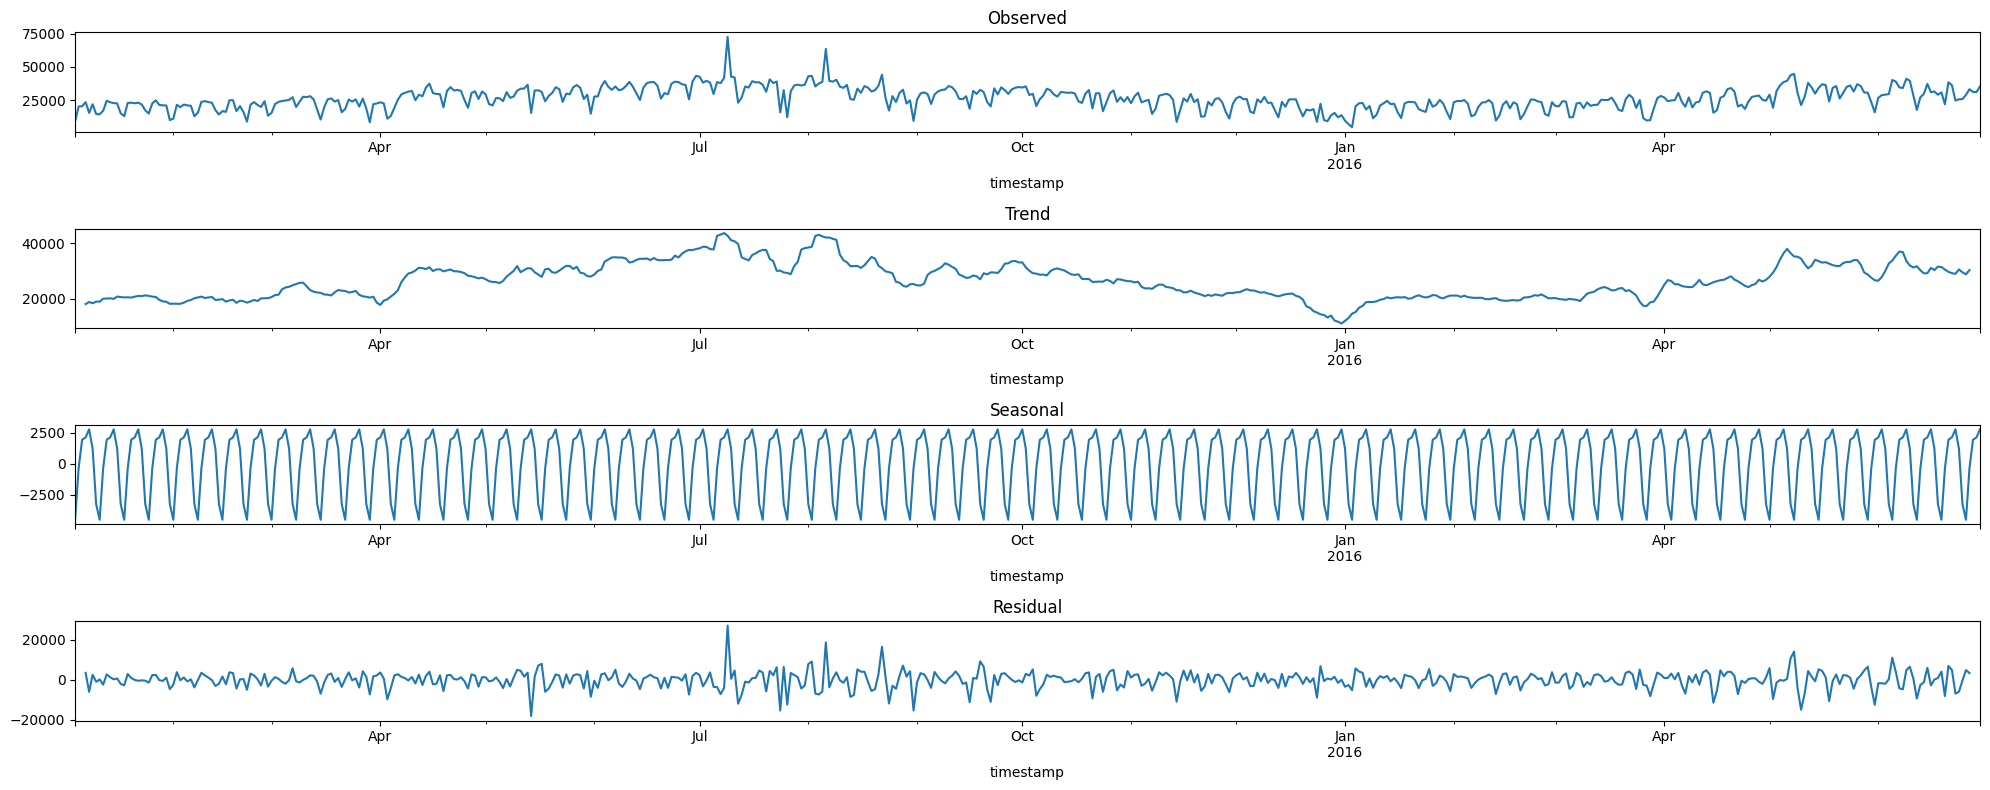

In [27]:
#Plot seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

fig_df = train_df.copy()
fig_df = fig_df.asfreq('D')
fig_df.index = pd.DatetimeIndex(fig_df.index.to_timestamp())
print(fig_df.index.freq)
fig, axes = plt.subplots(4, 1, figsize=(20, 8))
seasonal_decompose = seasonal_decompose(fig_df['cnt'], model='additive')
seasonal_decompose.observed.plot(ax=axes[0], title='Observed')
seasonal_decompose.trend.plot(ax=axes[1], title='Trend')
seasonal_decompose.seasonal.plot(ax=axes[2], title='Seasonal')
seasonal_decompose.resid.plot(ax=axes[3], title='Residual')
plt.tight_layout()
plt.show()

There is clear seasonality in the data. Also, the data does not look stationary.

### Check for stationarity

In [28]:
def check_stationarity(data):
    print('Null Hypothesis: Presence of unit root (Data is not stationary)')
    print('Alternate Hypothesis: Absence of unit root (Data is stationary)')
    result = adfuller(data, autolag='AIC')
    print(result)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] > 0.05:
        print('Data is not stationary')
    else:
        print('Data is stationary')

check_stationarity(train_df['cnt'])

Null Hypothesis: Presence of unit root (Data is not stationary)
Alternate Hypothesis: Absence of unit root (Data is stationary)
(-2.134764140765682, 0.23076740880382357, 14, 529, {'1%': -3.442772146350605, '5%': -2.8670191055991836, '10%': -2.5696881663873414}, 10503.323249600502)
ADF Statistic: -2.134764140765682
p-value: 0.23076740880382357
Data is not stationary


Hence, the models to be used should be able to handle seasonality and non-stationarity. SARIMAX might be a good choice. However, there are multiple seasonalities in the data which might be difficult to capture with SARIMAX. We will use XGBoost, LSTM and Prophet for this task. Let's still try SARIMAX and see how it performs.

# Models

## SARIMAX

- We will use Auto ARIMA to find the best parameter and not rely only on the ACF and PACF plots. However, ACF and PACF plots are useful to define the search space for Auto ARIMA. It is to note that Auto Arima leads to memory issue for high order models. Therefore, we will limit the search space.

In [ ]:
from sarimax import SARIMAX_model, SARIMAX_metrics, SARIMAX_plot
sarimax_y_train, sarimax_y_test, sarimax_y_pred = SARIMAX_model(train_df, test_df)

In [ ]:
sarimax_test_metrics = SARIMAX_metrics(sarimax_y_test, sarimax_y_pred)
sarimax_test_metrics

In [ ]:
#Plot predictions
SARIMAX_plot(sarimax_y_train, sarimax_y_test, sarimax_y_pred)

## XGBoost

In [ ]:
from XGBoost import xgboost_model, xgboost_metrics, xgboost_plot
xgboost_y_train, xgboost_y_test, xgboost_y_pred = xgboost_model(train_train_df, val_df, test_df)

In [ ]:
xgb_test_metrics = xgboost_metrics(xgboost_y_test, xgboost_y_pred)
xgb_test_metrics

In [ ]:
#Plot predictions
xgboost_plot(train_df, test_df, xgboost_y_pred)

## Prophet

In [ ]:
from Prophet import prophet_model, prophet_metrics, prophet_plot
prophet_test_df, prophet_y_pred = prophet_model(train_df, test_df)

In [ ]:
prophet_test_metrics = prophet_metrics(prophet_test_df, prophet_y_pred)
prophet_test_metrics

In [ ]:
#Plot predictions
prophet_plot(train_df, test_df, prophet_y_pred)

## LSTM with encoder and decoder

In [29]:
from lstm_encode_decode import lstm_model, lstm_metrics, lstm_plot
lstm_y_test, lstm_y_pred = lstm_model(train_train_df,
                                        val_df,
                                        test_df,
                                        lookback=28,
                                        forecast_horizon=7,
                                        )

[I 2024-07-18 11:51:40,867] A new study created in RDB with name: lstm_study


  0%|          | 0/2 [00:00<?, ?it/s]


[I 2024-07-18 11:53:43,863] Trial 0 finished with value: 16924616.0 and parameters: {'latent_dim': 32, 'num_layers': 1, 'dense_units': 128, 'dropout': 0.4, 'learning_rate': 0.0005318033256270141}. Best is trial 0 with value: 16924616.0.
[I 2024-07-18 11:55:44,492] Trial 1 finished with value: 20279958.0 and parameters: {'latent_dim': 16, 'num_layers': 1, 'dense_units': 64, 'dropout': 0.4, 'learning_rate': 0.0007593739613361233}. Best is trial 0 with value: 16924616.0.
Epoch 1/300
419/419 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 729487360.0000 - mape: 97.8060 - val_loss: 650025984.0000 - val_mape: 76.5667
Epoch 2/300
419/419 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 218766176.0000 - mape: 50.4187 - val_loss: 145207344.0000 - val_mape: 31.5149
Epoch 3/300
419/419 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 69217544.0000 - mape: 27.8521 - val_loss: 149531408.0000 - val_mape: 32.1669
Epoch 4/300
419/419 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 65028792.0000 - mape: 26.5641 - val_loss: 1597699

In [30]:
lstm_test_metrics = lstm_metrics(lstm_y_test, lstm_y_pred)
lstm_test_metrics

{'RMSE': 4371.483070576479,
 'MAE': 3210.22119140625,
 'MAPE': 11.83534558036667,
 'R2': 0.7433593991448086}

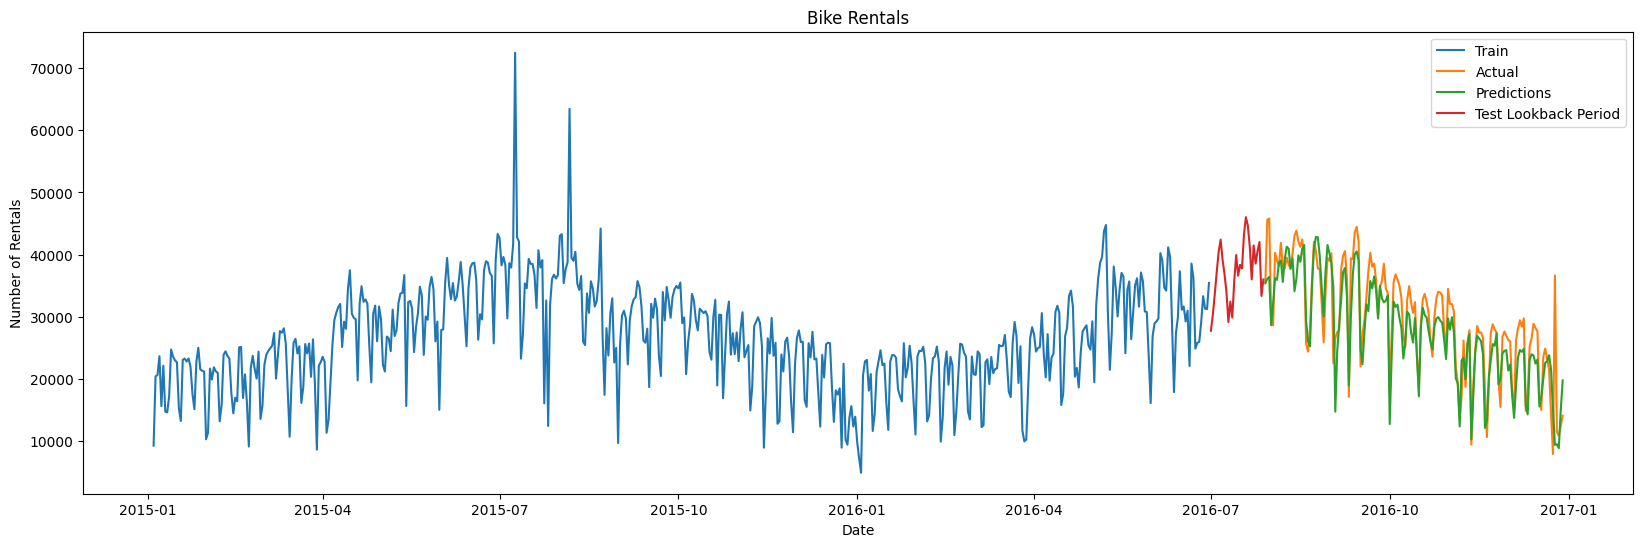

In [31]:
#Plot predictions
lstm_plot(train_df, test_df, lstm_y_pred, lookback=28)